In [1]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Embedding, TimeDistributed, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [4]:
loaded_piano_rolls = np.load('input-data/piano_rolls/classical/piano_rolls.npy', allow_pickle=True)

In [3]:
input_data = np.load('input-data/note_sequences/network_input.npy', allow_pickle=True)
output_data = np.load('input-data/note_sequences/network_output.npy', allow_pickle=True)


## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.utils import np_utils

model = Sequential()
model.add(LSTM(512, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(561, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.fit(input_data, output_data, epochs=100, batch_size=128)


## Модель LSTM Autoencoder

Здесь будет VAE

 ![](https://magenta.tensorflow.org/assets/music_vae/nsynth-ae.png)
 
 




In [64]:
# np.save('generated/piano_rolls/classical/piano_rolls.npy', generated_data)

VAE с иерархическим декодером

In [5]:
from keras.layers import Input, LSTM, RepeatVector, Dense, Flatten, Lambda, Reshape, Dropout
from keras.models import Model
from keras.losses import mse, binary_crossentropy
import keras.backend as K
from keras import regularizers

# Входные данные
input_dim = (1000, 128)
inputs = Input(shape=input_dim, name='encoder_input')

# Энкодер
latent_dim = 128
intermediate_dim = 512

x = LSTM(intermediate_dim, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), dropout=0.2)(inputs)
z_mean = Dense(latent_dim, name='z_mean', kernel_regularizer=regularizers.l2(1e-4))(x)
z_log_var = Dense(latent_dim, name='z_log_var', kernel_regularizer=regularizers.l2(1e-4))(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Декодер
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
h_decoded = RepeatVector(input_dim[0])(decoder_input)
h_decoded = LSTM(intermediate_dim, return_sequences=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), dropout=0.2)(h_decoded)
outputs = Dense(input_dim[1], activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(h_decoded)

# Иерархический декодер
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
outputs = Reshape(input_dim)(outputs)

# Функция потерь VAE
def vae_loss(inputs, outputs):
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= input_dim[0] * input_dim[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss

# Модель VAE
vae = Model(inputs, outputs, name='vae')
vae.add_loss(vae_loss(inputs, outputs))
vae.compile(optimizer='adam')


filepath = "weights/classical/weights-{epoch:02d}-{loss:.4f}-bigger.hdf5"

checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
)

callbacks_list = [checkpoint]

vae.load_weights("weights/classical/weights-04-2541.7168-bigger.hdf5")

vae.fit(x=loaded_piano_rolls, y=loaded_piano_rolls, epochs=1000, batch_size=128,  callbacks=callbacks_list)
# vae.save("gdrive/MyDrive/weights_1000_l.h5")


Epoch 1/1000
 8/23 [=========>....................] - ETA: 33:57 - loss: 2534.1296

In [5]:
example = vae.predict(loaded_piano_rolls[0:10])

1/1 [==============================] - 2s 2s/step


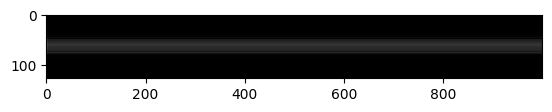

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(example[1]), cmap="gray")

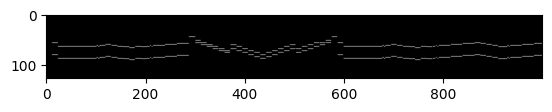

In [7]:
plt.imshow(np.transpose(loaded_piano_rolls[0]), cmap="gray")